In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os  
import warnings
warnings.filterwarnings('ignore')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#The '2' output stream only prints error messages; other miscellaneous information is not printed.

# Data acquisition
Load train, Val and test data

In [7]:
# Load training set data
filepath1 = 'train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath1,
    label_mode='categorical',  # "int", "categorical"means onehot, "binary", or None
    seed=123,
    image_size=(64, 64),  # Resize the image to the size we want
    batch_size=64)

# Load validation set data
filepath2 = 'Val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath2,
    label_mode='categorical',
    seed=123,
    image_size=(64, 64),
    batch_size=64)

#Load test set data
filepath3 = 'test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath3,
    label_mode='int',
    seed=123,
    image_size=(64, 64),
    batch_size=64)

# Class name
class_names = train_ds.class_names
print('Class names：',class_names)
# ['cats', 'dogs', 'panda']

Found 2995 files belonging to 3 classes.
Found 299 files belonging to 3 classes.
Found 297 files belonging to 3 classes.
Class names： ['cats', 'dogs', 'panda']


# Photo processing

img.shape: (64, 64, 64, 3)
label.shape: (64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

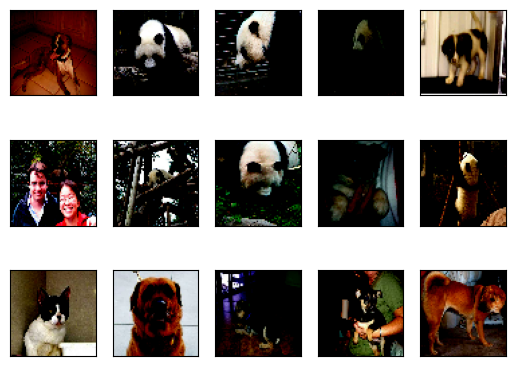

In [8]:
def processing(image, label):
    image = 2 * tf.cast(image, tf.float32) / 255.0 - 1  #between[-1,1]
    label = tf.cast(label, tf.int32)  # Modify data type
    return (image, label)

# shuffle
train_ds = train_ds.map(processing).shuffle(10000) 
val_ds = val_ds.map(processing).shuffle(10000)
test_ds = test_ds.map(processing).shuffle(10000)

# Data check
for img, label in train_ds.take(1): # Take out the data of a batch, which contains 64 samples.
    print('img.shape:', img.shape)   # img.shape: (64, 128, 128, 3)
    print('label.shape:', label.shape)  # label.shape: (64, 3)

# Show Data set display
import matplotlib.pyplot as plt
for img,label in train_ds.take(1): 
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(img[i])  
        plt.xticks([])  
        plt.yticks([])
plt.show()

# Build Model
VGG frame

In [13]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense


model = Sequential()
chanDim = 1
inputShape = (64, 64, 3)

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 3 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FC layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# softmax classification,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)
model.add(Dense(len(class_names)))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 64, 64, 32)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)       

# Training configuration & Training

In [16]:
from tensorflow.keras import optimizers

# Set dynamic learning rate with exponential decay.
exponential_decay = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=0.001, #Initial learning rate
                        decay_steps=2,  # Decay step size
                        decay_rate=0.96)  # Decay rate

# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=exponential_decay),
                loss=tf.losses.CategoricalCrossentropy(from_logits=True), # Cross entropy loss
                metrics=['accuracy'])  # Accuracy index

# Early stopping strategy
# When training doesn’t improve anything, stop training
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', # The accuracy of the validation set as an indicator
    patience = 5, # The maximum number of cycles that can be tolerated without improvement
    restore_best_weights = True)  # When stopping prematurely, automatically find the optimal monitor parameters.

History = model.fit(train_ds,  # Training set
                    validation_data=val_ds,  # Validation set
                    epochs=35,  # Number of iterations
                    callbacks= early_stopping, # Callback function, called at appropriate times during the training process
                    shuffle = True, # Shuffle before each iteration
                    verbose = 1 # 0: Do not output log information to the standard output stream, 1: Display a progress bar, 2: Output one line of records for each epoch
                    )

NameError: name 'optimizers' is not defined

# Model evaluation

Text(0.5, 1.0, 'Loss')

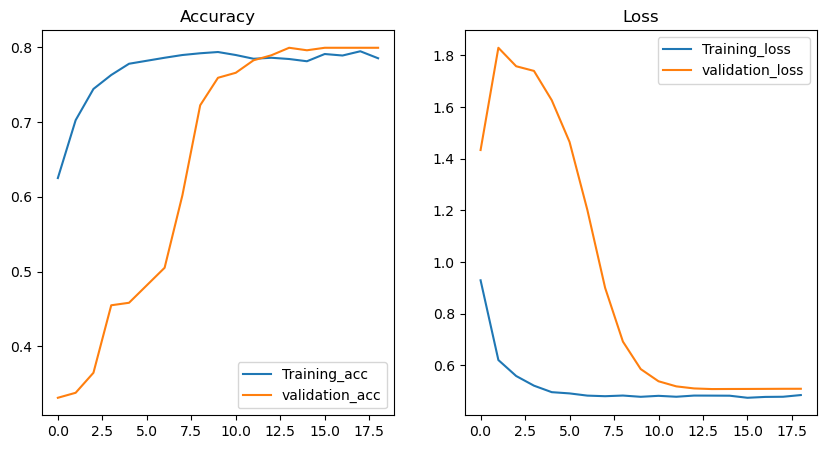

In [22]:
# ==1== Calculate accuracy
train_acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

# ==2== Loss
train_loss = History.history['loss']
val_loss = History.history['val_loss']

# ==3== Graph
epochs_range = range(len(train_acc))  # Abscissa: number of network cycles

# accuracy curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training_acc')
plt.plot(epochs_range, val_acc, label='validation_acc')
plt.legend()
plt.title('Accuracy')

# loss curve
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training_loss')
plt.plot(epochs_range, val_loss, label='validation_loss')
plt.legend()
plt.title('Loss')

# Confusion matrix

In [ ]:
test_pred = []
test_target = []

for images, targets in test_ds:  #Take a batch test set to generate a confusion matrix

    for image, label in zip(images, targets): # Take out one group from the batch each time
        # Need to add a dimension to the image
        img_array = tf.expand_dims(image, axis=0)
        # Using models to predict animals in pictures
        prediction = network.predict(img_array)
        # The prediction result is the position corresponding to the index of the maximum value of the predicted value
        test_pred.append(class_names[np.argmax(prediction)])
        # Labels that hold the true value
        test_target.append(class_names[label])  
        
print('Train Results:',test_pred[:10])
print('Real Results:',test_target[:10])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Generate confusion matrix
conf_numpy = confusion_matrix(test_target, test_pred)
# Convert matrix to DataFrame
conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)

plt.figure(figsize=(8,7))

sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")

plt.title('Confusion matrix')
plt.ylabel('Correct value')
plt.xlabel('Predictive value')